# Assigment 3

Name: Aibota Sanatbyek <br>
Matric No: S2017629 <br>
- Compared at least two supervised learning methods: SVM and LogisticRegression
<br>
- Modeled at least two affect: "Challenge", "Anxiety" <br>
Modalities used: physio, gameplay, keystroke <br>
How initial results are improved: hyperparameter tuning
- The result for the SVM model was able to improve from 0.495 to 0.56 after hyperparameter tuning
- The result for the Logistic Regression model improved very slightly from 0.5225 to 0.5232 after hyperparameter tuning


In [1]:
!pip install neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 10.5 MB/s eta 0:00:00


In [64]:
# load Python packages
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
from tqdm import tqdm
import xgboost
import shap

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

import itertools



import warnings
warnings.filterwarnings("ignore")

In [3]:
!wget https://niloosoleimani.com/w1/mazeball.json

--2024-01-19 13:58:36--  https://niloosoleimani.com/w1/mazeball.json
Resolving niloosoleimani.com (niloosoleimani.com)... 69.160.80.233
Connecting to niloosoleimani.com (niloosoleimani.com)|69.160.80.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35830852 (34M) [application/json]
Saving to: ‘mazeball.json’

mazeball.json       100%[===================>]  34.17M  23.3MB/s    in 1.5s    

2024-01-19 13:58:38 (23.3 MB/s) - ‘mazeball.json’ saved [35830852/35830852]



In [4]:
# load Maze Ball dataset
mb_data = pd.read_json("./mazeball.json")
mb_data = mb_data.mazeball.apply(pd.Series)
# data entries
mb_data.keys()

Index(['demographics', 'games', 'tutorial'], dtype='object')

In [5]:
# player demographics
# each entry contains demographic information for one player
p_demo = mb_data['demographics']
p_games = mb_data['games']
p_tutorial = mb_data['tutorial']
print("There are {} players in the dataset.".format(p_demo.shape))

There are (36,) players in the dataset.


In [6]:
# let's take the first player as an example
player_no = 0
print("Player information: ")
print(p_demo[player_no])

p_games = mb_data['games']
print("Number of sets of games played by this player is {}".format(np.shape(p_games[player_no])))

Player information: 
{'player_id': 1, 'age': 26, 'male': 1, 'playgames': 1, 'playgamesfrequency': 5}
Number of sets of games played by this player is (4,)


In [7]:
# let's take set 0 as an example
game_set_no = 0

# each entry contains game data and player preferences
p_games[player_no][game_set_no].keys()

dict_keys(['data', 'preferences'])

In [8]:
p_games_data = p_games[player_no][game_set_no]['data']
p_games_pref = p_games[player_no][game_set_no]['preferences']

print("Information in data: ", p_games_data.keys())
print("Information in pref: ", p_games_pref.keys())

Information in data:  dict_keys(['A', 'B'])
Information in pref:  dict_keys(['anxiety', 'challenge', 'excitement', 'boredom', 'frustration', 'relaxation', 'fun'])


In [9]:
# in each set, players played Game A and Game B
# for subjective ratings, players were asked whether they felt more "Anxiety" or "Challenge" etc when playing Game A or Game B
print(p_games_pref['anxiety'])
print(p_games_pref['challenge'])
print(p_games_pref['excitement'])
print(p_games_pref['boredom'])
print(p_games_pref['frustration'])
print(p_games_pref['relaxation'])
print(p_games_pref['fun'])

B
B
B
A
Both equally
Both equally
B


In [10]:
print("Physiological signals include ", p_games_data['A'][game_set_no]['physio'].keys())

Physiological signals include  dict_keys(['SC', 'BVP', 'time'])


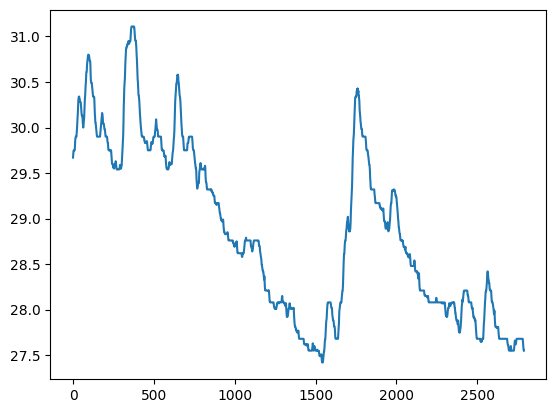

In [11]:
sample_signal = p_games_data['A'][game_set_no]['physio']['SC']
plt.plot(sample_signal)

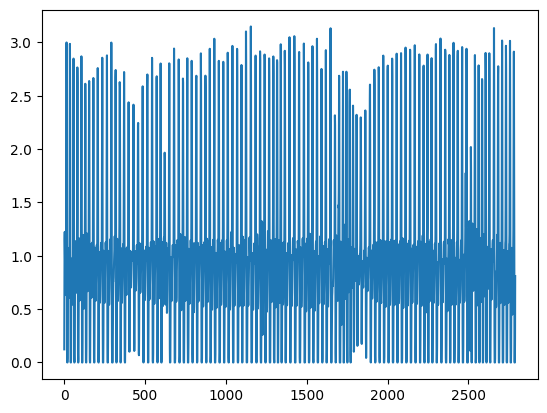

In [ ]:
sample_signal = p_games_data['A'][game_set_no]['physio']['BVP']
plt.plot(sample_signal)

In [ ]:
# time stamps for data recording; one sample measured every 0.03 seconds
# print(p_games_data['A'][game_set_no]['physio']['time'])
print("Sampling rate is {:.1f} Hz".format(1./p_games_data['A'][game_set_no]['physio']['time'][1]))

Sampling rate is 31.3 Hz


In [12]:
# perform feature extraction on the SC signal and the BVP signal before classification
# extract features
df, info = nk.eda_process(p_games_data['A'][game_set_no]['physio']['SC'], sampling_rate=31)

features_sc = {
    'scr_amplitude_mean': np.nanmean(info['SCR_Amplitude']),
    'scr_amplitude_std': np.nanstd(info['SCR_Amplitude']),
    'scr_risetime_mean': np.nanmean(info['SCR_RiseTime']),
    'scr_risetime_std': np.nanstd(info['SCR_RiseTime']),
    'scr_recoverytime_mean': np.nanmean(info['SCR_RecoveryTime']),
    'scr_recoverytime_std': np.nanstd(info['SCR_RecoveryTime']),
}

In [13]:
df, info = nk.ppg_process(p_games_data['A'][game_set_no]['physio']['BVP'], sampling_rate=31)
features_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
print(features_bvp)

   PPG_Rate_Mean   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  \
0      58.493213  1050.094877  438.008438         NaN         NaN         NaN   

   HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD  ...  HRV_SampEn  \
0         NaN         NaN         NaN  601.138193  ...    0.766891   

   HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
0    3.803323     0.837509  0.821202   0.940219     0.88641  0.768738   

    HRV_HFD  HRV_KFD   HRV_LZC  
0  1.968995  2.71138  0.904855  

[1 rows x 83 columns]


In [14]:
def extract_sc(signal):
    df, info = nk.eda_process(signal, sampling_rate=31)

    features_sc = np.array([
        np.nanmean(info['SCR_Amplitude']),
        np.nanstd(info['SCR_Amplitude']),
        np.nanmean(info['SCR_RiseTime']),
        np.nanstd(info['SCR_RiseTime']),
        np.nanmean(info['SCR_RecoveryTime']),
        np.nanstd(info['SCR_RecoveryTime'])
        ])

    feature_sc_names = [
        'SCR_Amplitude_mean',
        'SCR_Amplitude_std',
        'SCR_RiseTime_mean',
        'SCR_RiseTime_std',
        'SCR_RecoveryTime_mean',
        'SCR_RecoveryTime_std'
        ]

    return features_sc, feature_sc_names

def extract_bvp(signal):
    df, info = nk.ppg_process(p_games_data['A'][game_set_no]['physio']['BVP'], sampling_rate=31)
    feature_bvp = nk.ppg_intervalrelated(df, sampling_rate=31)
    feature_bvp_names = list(feature_bvp)

    return feature_bvp.to_numpy()[0], feature_bvp_names

In [15]:
alldata = {
    # demographics
    'player_id': [],
    'player_age': [],
    'player_gender': [],
    'player_playgames': [],
    'player_playfrequency': [],

    # games
    'game_variant': [],
    'features_gameplay': [],
    'features_keystrokes': [],
    'features_sc': [],
    'features_bvp': [],

    'class': [], # anxiety, challenge, excitement, boredom, frustration, relaxation, fun
    }

# which affective data to collect?
c_list = ["anxiety", "challenge"]

for c in c_list:
    for a in tqdm(range(36)): # player number
        player_demographics = p_demo[a] # player demographics
        player_game = p_games[a]
        player_tutorial = p_tutorial[a]

        for b in range(len(player_game)): # game number
            game_pref = p_games[a][b]['preferences']
            game_a = p_games[a][b]['data']['A'][0]
            game_b = p_games[a][b]['data']['B']

            # # Game A gameplay features
            #print(game_a['gameplay'].keys()) # in 90 seconds, how many data samples?

            # # Game A keystroke features
            #print(game_a['keystrokes'].keys()) # in 90 seconds, how many data samples?

            # # Game A physiological features
            #print(game_a['physio'].keys()) # in 90 seconds, how many data samples?
            features_sc_a, features_sc_names = extract_sc(game_a['physio']['SC'])
            features_bvp_a, features_bvp_names = extract_bvp(game_a['physio']['BVP'])

            # Game B physiological features
            features_sc_b, _ = extract_sc(game_b['physio']['SC'])
            features_bvp_b, _ = extract_bvp(game_b['physio']['BVP'])


            # append information for Game A
            alldata['player_id'] += [player_demographics['player_id']]
            alldata['player_age'] += [player_demographics['age']]
            alldata['player_gender'] += [player_demographics['male']]
            alldata['player_playgames'] += [player_demographics['playgames']]
            alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

            alldata['game_variant'] += [game_a['variant']]
            alldata['features_sc'] += [features_sc_a]
            alldata['features_bvp'] += [features_bvp_a]

            # append information for Game B
            alldata['player_id'] += [player_demographics['player_id']]
            alldata['player_age'] += [player_demographics['age']]
            alldata['player_gender'] += [player_demographics['male']]
            alldata['player_playgames'] += [player_demographics['playgames']]
            alldata['player_playfrequency'] += [player_demographics['playgamesfrequency']]

            alldata['game_variant'] += [game_a['variant']]
            alldata['features_sc'] += [features_sc_b]
            alldata['features_bvp'] += [features_bvp_b]

            # generate labels based on preference ranking
            if game_pref[c] == "A": # if game A is more preferred than game B
                alldata['class'] += [1] # class label for Game A
                alldata['class'] += [0] # class label for Game B

            elif game_pref[c] == "B": # if game B is more preferred
                alldata['class'] += [0]
                alldata['class'] += [1]

            elif game_pref[c] == "Both equally":
                alldata['class'] += [1]
                alldata['class'] += [1]

            elif game_pref[c] == "Neither":
                alldata['class'] += [0]
                alldata['class'] += [0]

100%|██████████| 36/36 [00:53<00:00,  1.49s/it]


In [16]:
print(game_a['keystrokes'].keys())

print(game_a['gameplay'].keys())
print(game_a['gameplay']['event'][0])

dict_keys(['leftpressed', 'uppressed', 'spacepressed', 'rightpressed', 'time', 'downpressed'])
dict_keys(['event', 'score', 'distance2pellets_euclidean', 'time', 'distance2enemies_path', 'distance2camera', 'distance2enemies_euclidean', 'mapdiscovered', 'tilevisits', 'distance2pellets_path'])
ChangeTile


In [17]:
# create dataset
X = [] # training data
Y = [] # class label
Z = [] # player id for cross-validation
for i in range(len(alldata['class'])):
    # Extract physiological features
    features_sc = alldata['features_sc'][i]
    features_bvp = alldata['features_bvp'][i]

    # Extract keystroke features
    keystrokes = game_a['keystrokes']
    features_keystrokes = np.array([
        np.mean(keystrokes['leftpressed']),
        np.mean(keystrokes['uppressed']),
        np.mean(keystrokes['spacepressed']),
        np.mean(keystrokes['rightpressed']),
        np.mean(keystrokes['time']),
        np.mean(keystrokes['downpressed'])
    ])

    # Extract gameplay features
    gameplay = game_a['gameplay']
    features_gameplay = np.array([
        #np.mean(gameplay['event']),
        np.mean(gameplay['score']),
        np.mean(gameplay['distance2pellets_euclidean']),
        np.mean(gameplay['time']),
        np.mean(gameplay['distance2enemies_path']),
        np.mean(gameplay['distance2camera']),
        np.mean(gameplay['distance2enemies_euclidean']),
        np.mean(gameplay['mapdiscovered']),
        np.mean(gameplay['tilevisits']),
        np.mean(gameplay['distance2pellets_path']),
    ])

    vec = np.concatenate([
        np.array([alldata['player_age'][i],
                alldata['player_gender'][i],
                alldata['player_playgames'][i],
                alldata['player_playfrequency'][i],
                alldata['game_variant'][i]
            ]),
        alldata['features_sc'][i],
        alldata['features_bvp'][i],
        features_sc,
        features_bvp,
        features_keystrokes,
        features_gameplay
        ])
    X += [vec.astype(float)]
    Y += [alldata['class'][i]]
    Z += [alldata['player_id'][i]]

feature_names = []
feature_names += ['player_age']
feature_names += ['player_gender']
feature_names += ['player_playgames']
feature_names += ['player_playfrequency']
feature_names += ['game_variant']
feature_names += features_sc_names
feature_names += features_bvp_names

# Add keystroke feature names here
feature_names += ['mean_leftpressed', 'mean_uppressed', 'mean_spacepressed', 'mean_rightpressed', 'mean_downpressed']
# Add gameplay feature names here
feature_names += ['mean_score', 'mean_distance2pellets_euclidean', 'mean_distance2enemies_path', 'mean_distance2camera', 'mean_distance2enemies_euclidean', 'mean_mapdiscovered', 'mean_tilevisits', 'mean_distance2pellets_path']


X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)
player_id = np.unique(Z)


# SVM

In [43]:
# divide into training and testing;
# leave-one-person-out: X-1 persons for training, 1 person for testing
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imp.fit_transform(X)
predictions_svm = []
labels_svm = []
for idx in player_id:
    istrain = Z!=idx
    istest = Z==idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]

    # create a new model for each crossvalidation
    model_svm = SVC(kernel='rbf')
    model_svm.fit(X_train, Y_train)

    # test the model
    Y_predicted = model_svm.predict(X_test)

    predictions_svm += [Y_predicted]
    labels_svm += [Y_test]

In [44]:
svm_accuracy = np.mean(np.concatenate(predictions_svm) == np.concatenate(labels_svm))
print(svm_accuracy)

0.4947916666666667


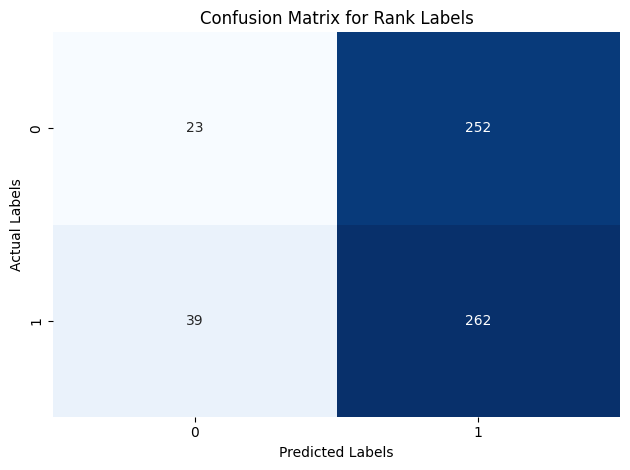

In [45]:
# Confusion matrix
conf_matrix = confusion_matrix(np.concatenate(labels_svm), np.concatenate(predictions_svm))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

plt.tight_layout()
plt.show()

# Linear Regression

In [46]:
logreg_predictions = []
logreg_labels = []
for idx in player_id:
    istrain = Z!=idx
    istest = Z==idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]

    # create a new model for each crossvalidation
    logreg_model = LogisticRegression()
    logreg_model.fit(X_train, Y_train)

    # test the model
    Y_predicted = logreg_model.predict(X_test)

    logreg_predictions += [Y_predicted]
    logreg_labels += [Y_test]

In [47]:
logreg_accuracy = np.mean(np.concatenate(logreg_predictions) == np.concatenate(logreg_labels))
print(logreg_accuracy)

0.5225694444444444


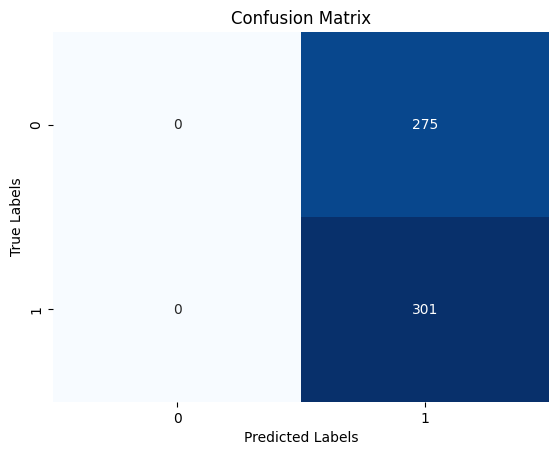

In [48]:
# Confusion Matrix
conf_matrix = confusion_matrix(np.concatenate(logreg_labels), np.concatenate(logreg_predictions))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Improving the results through Hyperparameter Optimization

In [80]:
# SVM Classifier with updated hyperparameters
predictions_svm_new = []
labels_svm_new = []
for idx in player_id:
    istrain = Z!=idx
    istest = Z==idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]

    # create a new model for each crossvalidation
    model = SVC(kernel='rbf')
    C_range = [1,2,3,4]
    gamma_range = [1e-1, 1e-2, 1e-3, 1e-4]
    param_gs = dict(gamma=gamma_range, C=C_range)
    gs = GridSearchCV(model, param_grid=param_gs, cv=2, pre_dispatch='1*n_jobs', n_jobs=1)
    gs.fit(X_train,Y_train)

    # test the model
    Y_predicted = gs.predict(X_test)

    predictions_svm_new += [Y_predicted]
    labels_svm_new += [Y_test]

In [82]:
print(f'The best parameters are {gs.best_params_} with a best accuracy score of {gs.best_score_}')

The best parameters are {'C': 4, 'gamma': 0.1} with a best accuracy score of 0.5607142857142857


Text(0.5, 0, 'C range')

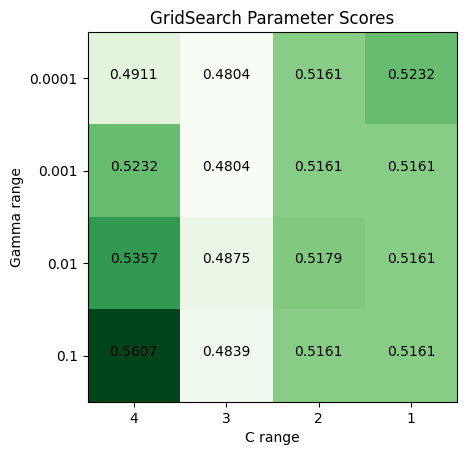

In [63]:
#Visualization
scores = gs.cv_results_['mean_test_score']
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

plt.imshow(scores, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("GridSearch Parameter Scores")
tick_marks = np.arange(len(C_range))
plt.xticks(tick_marks, reversed(C_range))
plt.yticks(tick_marks, reversed(gamma_range))
for i, j in itertools.product(range(scores.shape[0]), range(scores.shape[1])):
    plt.text(j, i, format(scores[i, j], '.4f'), horizontalalignment="center", color="black" if scores[i, j]<0.95 else "white")
plt.ylabel('Gamma range')
plt.xlabel('C range')

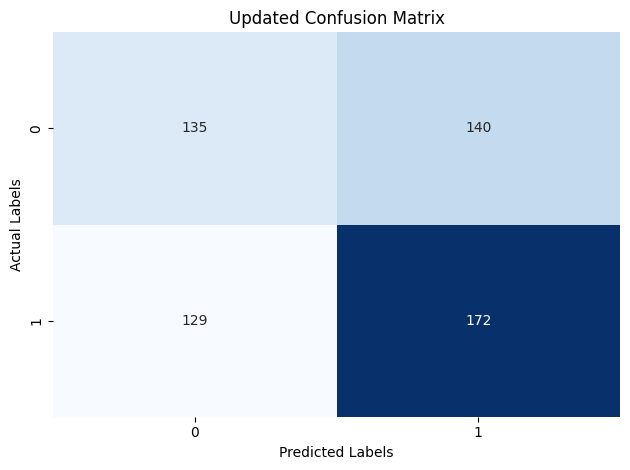

In [83]:
# Confusion matrix
conf_matrix = confusion_matrix(np.concatenate(labels_svm_new), np.concatenate(predictions_svm_new))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Updated Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

plt.tight_layout()
plt.show()

In [78]:
logreg_predictions_new = []
logreg_labels_new = []
for idx in player_id:
    istrain = Z!=idx
    istest = Z==idx

    X_train = X[istrain]
    X_test = X[istest]
    Y_train = Y[istrain]
    Y_test = Y[istest]

    # hyperparameter tuning
    param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
    grid_search.fit(X_train, Y_train)

    # test the model
    Y_predicted = grid_search.predict(X_test)

    logreg_predictions_new += [Y_predicted]
    logreg_labels_new += [Y_test]

In [79]:
print(f'The best parameters are {grid_search.best_params_} with a best accuracy score of {grid_search.best_score_}')

The best parameters are {'C': 0.0001} with a best accuracy score of 0.5232142857142857


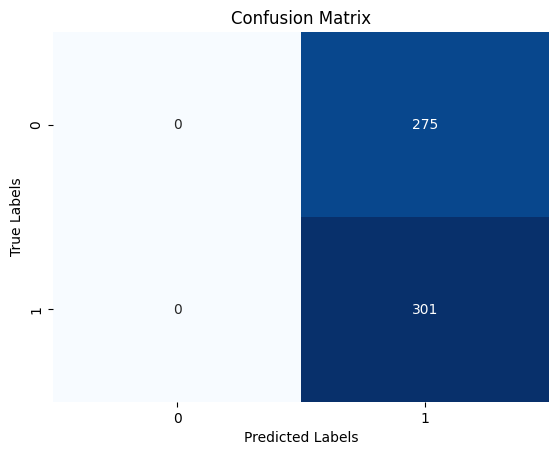

In [74]:
# Confusion Matrix
conf_matrix = confusion_matrix(np.concatenate(logreg_labels_new), np.concatenate(logreg_predictions_new))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()